# MolRL: Basic Usage

In [1]:
%load_ext autoreload 
%autoreload 2 

In [2]:
import molrl
import logging
import torch
import pandas as pd
import datamol as dm
import pytorch_lightning as pl 
import matplotlib.pyplot as plt 
import seaborn as sns
from rdkit.Chem import QED, MolFromSmiles
from molrl import SMILESVAERNNCAT, Vocab
from rdkit import Chem

## Define a scoring function

Here we define a simple reward function that checks if a molecule contains an Aminopyrimidine substructure & QED

In [3]:
sub = 'Nc1ncccn1' #Aminpyrimidine substructure 
sub_smarts = Chem.MolFromSmarts(sub)

In [4]:
def contains_substructure_and_qed(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        qed = dm.descriptors.qed(mol)
        if mol.HasSubstructMatch(sub_smarts):
            return 1 + qed
        else:
            return qed 
    except:
        return 0

reward_fn = molrl.BaseRewardSimple(calculator=contains_substructure_and_qed)

## Load a pre-trained model

In [5]:
device = "cuda:1"

In [6]:
vae = molrl.SMILESVAERNNCAT.load_from_checkpoint('../../vae-cyc/last-v2.ckpt').eval()
vae = molrl.VAEModel(vae)

annealing: cyclical


## Define the actor critc network

In [7]:
latent_size = vae.get_latent_size()
actor_critic = molrl.ActorCritic(
        input_dim=latent_size,
        action_dim=latent_size,
        hidden_dim=latent_size,
)

## Initialize the agent 

In [8]:
agent = molrl.PPOAgent(
            latent_model=vae,
            policy_net_latent=actor_critic,
            reward_fn=reward_fn,
            device="cuda:1",
    )

INFO:PPOAgent:Initialized PPOAgent on device: cuda:1


## Run optimization 

In [9]:
agent.train(
        epochs=100,
        random_seed=32,
        n_random_seeds=1,
        latent_size=64,
        batch_size=100,
        deterministic=False,
        learning_rate=0.001
    )

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s, episode_reward=0.823, loss=0.236, actor_loss=-0.105, critic_loss=0.577, entropy=-56.6, l2_loss=5.11, epoch=99, action_std=0.1, oracle_calls=1e+4, mean_top_k_reward=1.92, mean_top_k_unique=1.57, max_reward=1.92]


## Plot optimization results

In [10]:
train_metrics = pd.DataFrame(agent.train_metrics)

<Axes: xlabel='epoch', ylabel='episode_reward'>

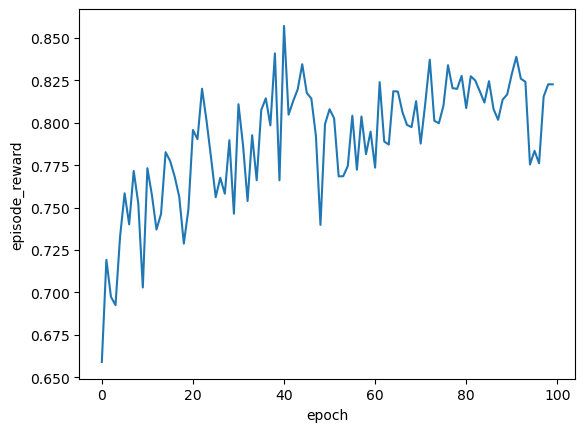

In [11]:
sns.lineplot(x='epoch', y='episode_reward', data=train_metrics)

## Visualize top results

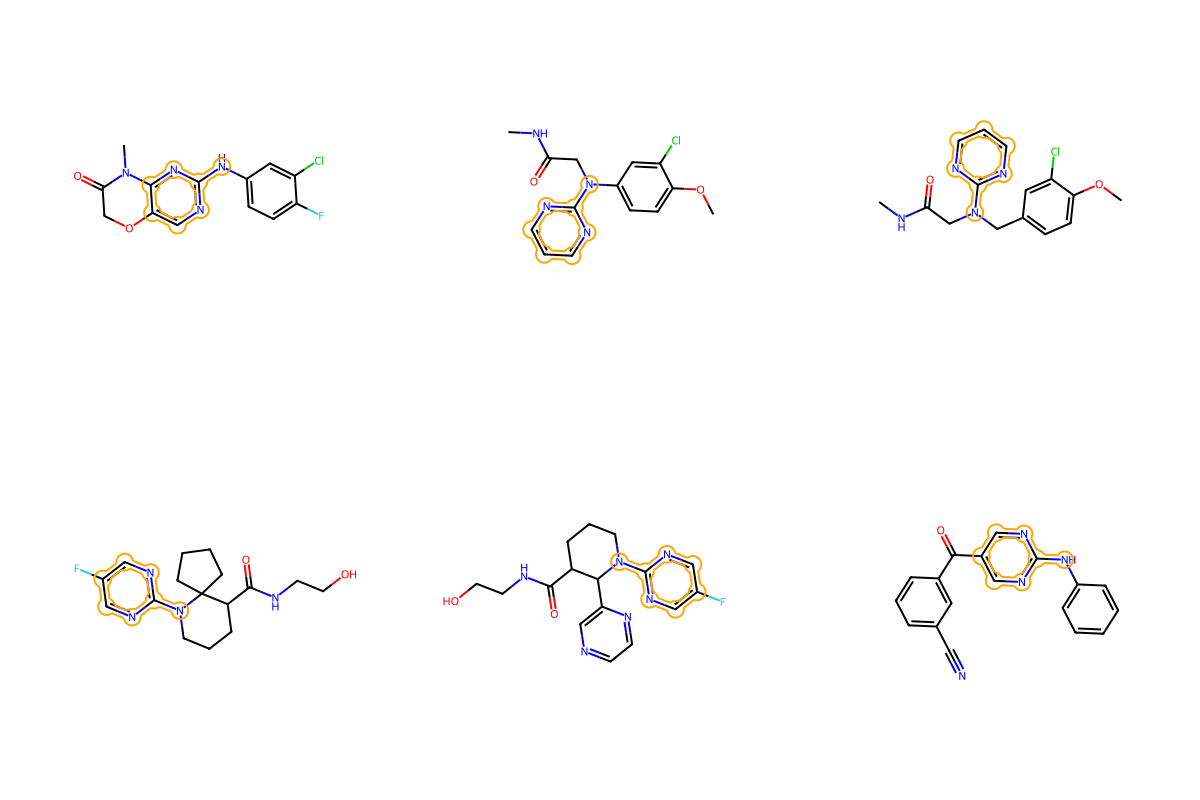

In [29]:
buffer = agent.buffer()
buffer = buffer.sort_values(by='reward', ascending=False)
buffer = buffer.drop_duplicates('new_smiles')
target_mols = [dm.to_mol(i) for i in buffer.new_smiles.values[0:6]]
search_mols = [sub_smarts]
dm.lasso_highlight_image(target_molecules=target_mols[0:6], search_molecules=search_mols, mol_size=(400, 400),n_cols=3,color_list=['orange'],use_svg=False)